<a href="https://colab.research.google.com/github/ThatoMkoni/ASU_CNN_TENSORFLOW/blob/main/ASU_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!uv pip install -q tensorflow
!uv pip install -q keras
!uv pip install -q scikit-learn
!uv pip install -q scikeras
!uv pip install -q librosa

In [2]:
!wget https://github.com/saraalemadi/DroneAudioDataset/archive/refs/heads/master.zip

!unzip /content/master.zip

Streaming output truncated to the last 5000 lines.
  inflating: DroneAudioDataset-master/Multiclass_Drone_Audio/unknown/3-163607-B-132.wav  
  inflating: DroneAudioDataset-master/Multiclass_Drone_Audio/unknown/3-163607-B-133.wav  
  inflating: DroneAudioDataset-master/Multiclass_Drone_Audio/unknown/3-163607-B-134.wav  
  inflating: DroneAudioDataset-master/Multiclass_Drone_Audio/unknown/3-163727-A-30.wav  
  inflating: DroneAudioDataset-master/Multiclass_Drone_Audio/unknown/3-163727-A-31.wav  
  inflating: DroneAudioDataset-master/Multiclass_Drone_Audio/unknown/3-163727-A-32.wav  
  inflating: DroneAudioDataset-master/Multiclass_Drone_Audio/unknown/3-163727-A-33.wav  
  inflating: DroneAudioDataset-master/Multiclass_Drone_Audio/unknown/3-163727-A-34.wav  
  inflating: DroneAudioDataset-master/Multiclass_Drone_Audio/unknown/3-164120-A-110.wav  
  inflating: DroneAudioDataset-master/Multiclass_Drone_Audio/unknown/3-164120-A-111.wav  
  inflating: DroneAudioDataset-master/Multiclass_Drone

In [3]:
# ML
import tensorflow as tf
import keras
import librosa
from keras import layers, models

# Stats
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [4]:
def load_wav_mono(filename):
    # Convert the TensorFlow Tensor filename to a string
    filename_str = filename.numpy().decode('utf-8')
    wav, sr = librosa.load(filename_str, sr=32000, mono=True)
    wav = tf.convert_to_tensor(wav, dtype=tf.float32)
    return wav

def preprocess(file_path, label):
    # Use tf.py_function to wrap the parts that need eager execution
    wav = tf.py_function(load_wav_mono, [file_path], Tout=tf.float32)
    samples = 32000 * 1 # STM32 Sample Rate * seconds
    wav.set_shape([None]) # Set shape to allow slicing
    wav = wav[:samples]
    zero_padding = tf.zeros([samples] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    spectogram = tf.signal.stft(wav, frame_length=256, frame_step = 256)
    spectogram = tf.abs(spectogram)
    spectogram = tf.expand_dims(spectogram, axis=2)
    return spectogram, label

In [5]:
# ensures reproducibliity as neurons are set at a known seed
seed = 7
tf.random.set_seed(seed)
np.random.seed(seed)


In [6]:

DATASET_PATH = '/content/DroneAudioDataset-master/Binary_Drone_Audio'
yes_drone_path = 'yes_drone/*.wav'
no_drone_path = 'unknown/*.wav'

POS = f'{DATASET_PATH}/{yes_drone_path}'
NEG = f'{DATASET_PATH}/{no_drone_path}'
pos = tf.data.Dataset.list_files(POS)
neg = tf.data.Dataset.list_files(NEG)
neg = neg.take(1332) # there is more neg data

positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))


In [7]:
data = positives.concatenate(negatives)
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(2664)
data = data.batch(32) # increasing batch size increases size in RAM
data = data.prefetch(tf.data.AUTOTUNE)
print("Data: ", len(data))

train = data.take(66)
test = data.skip(66).take(18)

samples, labels = train.as_numpy_iterator().next()  # type: ignore
print(samples.shape)

num_samples = set(int(i.shape[0]) for i in keras.tree.flatten(samples))

Data:  84
(32, 125, 129, 1)


In [8]:
model = models.Sequential(
    [
        layers.Input(shape=(125, 129, 1)),
        layers.Resizing(129, 32),
        layers.BatchNormalization(),

        layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu'),
        layers.Conv2D(filters=16, kernel_size=(2,2), activation='relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(filters=8, kernel_size=(2,2), activation='relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(filters=4, kernel_size=(2,2), activation='relu'),
        layers.GlobalAveragePooling2D(),

        layers.Dense(16, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid'),
    ]
)



In [9]:
optimiser = keras.optimizers.AdamW(learning_rate=7.5e-3, weight_decay=1e-4)
model.compile(optimiser, loss='BinaryCrossentropy', run_eagerly=True, metrics=[keras.metrics.Recall(), keras.metrics.Precision()])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 129, 32, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 129, 32, 1)     │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 31, 32)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 127, 30, 16)    │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 62, 14, 8)      │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 7, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 30, 6, 4)       │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 4)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,977 (11.63 KB)

 Trainable params: 2,975 (11.62 KB)

 Non-trainable params: 2 (8.00 B)

In [10]:
def schedular(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))


training_callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'ASU_CNN.keras',
        save_best_only=True,
        monitor='val_loss',
        mode = 'min'
    ),

    # keras.callbacks.EarlyStopping(
    #   monitor="val_loss",
    #   mode = 'min',
    #   patience=5, # waits 5 epochs before stopping
    #   restore_best_weights=True,
    #   verbose=1),

  #keras.callbacks.LearningRateScheduler(schedular),

  keras.callbacks.ReduceLROnPlateau(
      monitor="val_loss",
      factor=0.5, # reduce learning rate by 50%
      patience=10,
      min_lr = 1e-6,
      verbose=1
  )
]

In [11]:
hist = model.fit(train, epochs=150, validation_data=test, verbose='auto', callbacks=training_callbacks)


Epoch 1/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - loss: 0.6655 - precision: 0.5003 - recall: 0.2588 - val_loss: 0.6491 - val_precision: 0.5464 - val_recall: 0.9893 - learning_rate: 0.0075
Epoch 2/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - loss: 0.6076 - precision: 0.7250 - recall: 0.6523 - val_loss: 0.4818 - val_precision: 0.8633 - val_recall: 0.8727 - learning_rate: 0.0075
Epoch 3/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - loss: 0.5905 - precision: 0.6913 - recall: 0.7052 - val_loss: 0.4314 - val_precision: 0.8791 - val_recall: 0.8955 - learning_rate: 0.0075
Epoch 4/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - loss: 0.4966 - precision: 0.7781 - recall: 0.8372 - val_loss: 0.4676 - val_precision: 0.9465 - val_recall: 0.6460 - learning_rate: 0.0075
Epoch 5/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - loss: 0.4867 - precision: 0.8049 - recall: 0.8236 - val_loss: 0.3584 - val_precision: 0.8651 - val_recall: 0.9326 - learning_rate: 0.0075
Epoch 6/150
66/66 ━━━━━━━━━━━━━━━━━

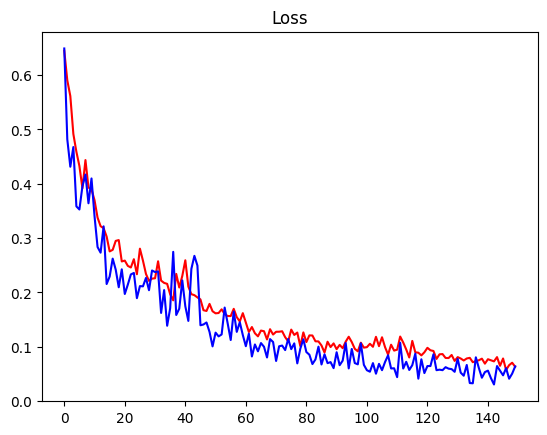

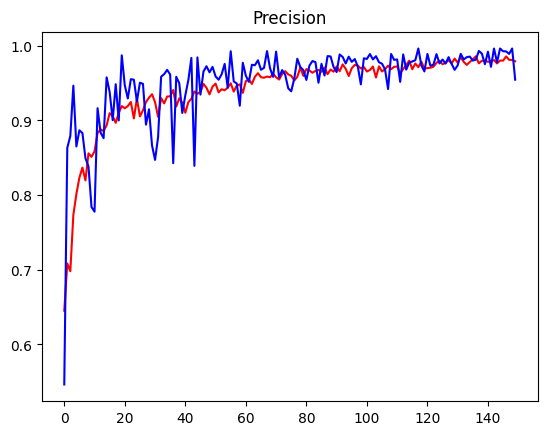

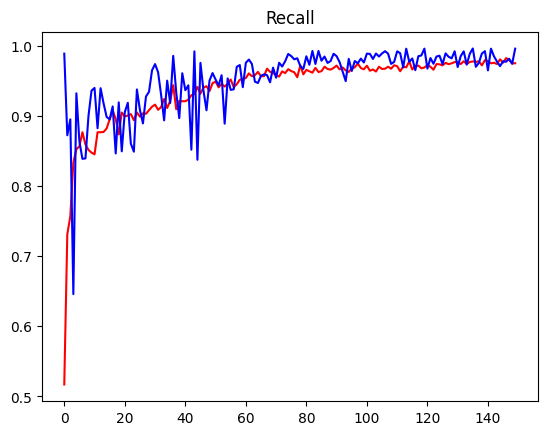

Test Prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Test Prediction result:  [[9.9916130e-01]
 [5.1569650e-03]
 [4.0920487e-12]
 [4.7908782e-33]
 [9.9896502e-01]
 [7.3896490e-06]
 [1.0217976e-01]
 [1.6874475e-02]
 [9.9799353e-01]
 [2.4299188e-02]
 [9.9656695e-01]
 [9.9286753e-01]
 [7.8968561e-01]
 [9.9876624e-01]
 [0.0000000e+00]
 [9.9770510e-01]
 [9.9699688e-01]
 [9.9202925e-01]
 [1.1024683e-02]
 [9.9944407e-01]
 [9.9909878e-01]
 [6.1921311e-17]
 [9.9906808e-01]
 [9.9793816e-01]
 [1.8187201e-02]
 [9.7406115e-03]
 [2.0461232e-05]
 [9.9352610e-01]
 [2.6390603e-01]
 [9.7111768e-01]
 [5.2604799e-05]
 [6.1130355e-04]]


In [13]:
# Training Stats
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

print("Test Prediction...")
test_prediction = model.predict(samples)
print("Test Prediction result: ", test_prediction)

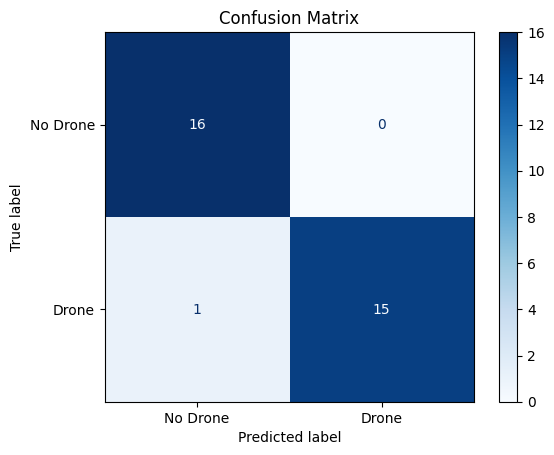


Confusion Matrix:
True Negatives: 16
False Positives: 0
False Negatives: 1
True Positives: 15


In [14]:
y_pred = (test_prediction > 0.95).astype(int)  #probabilities to binary predictions
y_true = labels  # labels from the test set

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Drone', 'Drone'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

print("\nConfusion Matrix:")
print(f"True Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

In [18]:
model.save("CNN_8.keras")

In [15]:
def segment_audio(audio_data, sample_rate, segment_duration=1):
    """
    Segments audio data into chunks of a specified duration.

    Args:
        audio_data (np.ndarray): The input audio data.
        sample_rate (int): The sample rate of the audio data.
        segment_duration (int): The desired duration of each segment in seconds.

    Returns:
        list: A list of audio segments.
    """
    samples_per_segment = segment_duration * sample_rate
    segments = []
    for i in range(0, len(audio_data), samples_per_segment):
        segment = audio_data[i:i + samples_per_segment]
        segments.append(segment)
    return segments

# Example usage:
# Assuming 'y' and 'sr' are loaded from the previous step
# segments = segment_audio(y, sr)
# print(f"Number of segments: {len(segments)}")

In [19]:
def preprocess_segment(segment, sample_rate, samples=32000):
    """
    Preprocesses a single audio segment for model inference.

    Args:
        segment (np.ndarray): The input audio segment.
        sample_rate (int): The sample rate of the audio data.
        samples (int): The desired number of samples per segment (default is 1 second * 32000 Hz).

    Returns:
        tf.Tensor: The preprocessed spectogram.
    """
    # Convert numpy array to TensorFlow Tensor
    wav = tf.convert_to_tensor(segment, dtype=tf.float32)

    # Ensure the segment has the correct number of samples (padding or truncating)
    if tf.shape(wav)[0] < samples:
        zero_padding = tf.zeros([samples] - tf.shape(wav), dtype=tf.float32)
        wav = tf.concat([zero_padding, wav], 0)
    elif tf.shape(wav)[0] > samples:
        wav = wav[:samples]

    # Compute the spectogram
    spectogram = tf.signal.stft(wav, frame_length=256, frame_step=256)
    spectogram = tf.abs(spectogram)

    # Add a channel dimension
    spectogram = tf.expand_dims(spectogram, axis=2)

    # Add a batch dimension
    spectogram = tf.expand_dims(spectogram, axis=0)

    return spectogram



In [39]:
long_audio_path = '/content/BACKGROUND_017.wav'
audio_path = '/content/DRONE_008.wav'
y, sr = librosa.load(audio_path, sr=32000, mono=True)

print(f"Loaded audio with sample rate {sr} and duration {len(y)/sr:.2f} seconds")

Loaded audio with sample rate 32000 and duration 10.00 seconds


In [40]:
segments = segment_audio(y, sr)
print(f"Number of segments: {len(segments)}")

# Preprocess the first segment
if segments:
    first_segment = segments[0]
    preprocessed_first_segment = preprocess_segment(first_segment, sr)
    print(f"Shape of the preprocessed first segment: {preprocessed_first_segment.shape}")
else:
    print("No segments to preprocess.")

Number of segments: 11
Shape of the preprocessed first segment: (1, 125, 129, 1)


In [67]:
saved_model = keras.models.load_model('CNN_7.keras')

In [42]:
predictions = []
for i, segment in enumerate(segments):
    # Preprocess the segment
    preprocessed_segment = preprocess_segment(segment, sr)

    # Make a prediction
    prediction = model.predict(preprocessed_segment)
    predictions.append(prediction)
    print(f"Prediction for segment {i}: {prediction}")

# The 'predictions' list now contains the model's output for each segment.
# You can further process this list to make a final decision for the entire audio file.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for segment 0: [[0.80796105]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for segment 1: [[0.08258021]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for segment 2: [[0.7991553]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for segment 3: [[0.74398214]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for segment 4: [[0.10755572]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for segment 5: [[0.04295966]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for segment 6: [[0.00364465]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for segment 7: [[0.17388211]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for segment 8: [[0.20304225]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for segment 9: [[0.01266668]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for segment 10: [[0.0181872]]
